<div style="text-align: center;">
    <h1><strong>Alma Mater Studiorum - University of Bologna</strong></h1>
    

<div style="display:flex; justify-content:center; align-items:center; padding:5px;">
        <img src="../reports/figs/image.png" style="height:300px; width:auto">
    </div>

<h2><strong>Optimal Control and Reinforcement Learning</strong></h2>

<h3><strong>PROYECT</strong><br>
    <strong>Optimal Control of a Gymnast Robot.</strong></h3>

<p><strong>STUDENTS</strong></p>
    <ul style="list-style-type:none; padding: 0;">
        <li><strong>Rubén Gil Martínez<strong></li>
        <li><strong>Guillermo López Pérez<strong></li>
    </ul>
</div>

1. **The State Space**

The system has two degrees of freedom (DoF) but is underactuated (only torque $\tau$ on the second joint). Let $q = [\theta_1, \theta_2]^\top$ and $\dot{q} = [\dot{\theta}_1, \dot{\theta}_2]^\top$. The state vector is $x = [\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2]^\top \in \mathbb{R}^4$. The control input is $u = [\tau] \in \mathbb{R}^1$.

2. **The Equations of Motion**

The material provides the dynamics in the standard manipulator form:

$$M(q)\ddot{q} + C(q, \dot{q})\dot{q} + F\dot{q} + G(q) = \begin{bmatrix} 0 \\ \tau \end{bmatrix}$$To simulate this, we need the forward dynamics (solving for acceleration):$$\ddot{q} = M(q)^{-1} \left( \begin{bmatrix} 0 \\ \tau \end{bmatrix} - C(q, \dot{q})\dot{q} - F\dot{q} - G(q) \right)$$


3. **System Parameters (Set 3)**

For this implementation, we will strictly adhere to Parameter Set 3 as defined in the project specifications. These parameters describe a robot with specific inertial properties, which will directly impact the control effort required for the swing-up maneuver. The configuration is as follows: 

- Masses: $m_1 = 1.5$ kg, $m_2 = 1.5$ kg
- Link Lengths: $l_1 = 2$ m, $l_2 = 2$ m
- Center of Mass Distances: $l_{c1} = 1$ m, $l_{c2} = 1$ m
- Moments of Inertia: $I_1 = 2$ kg·m², $I_2 = 2$ kg·m²
- Dynamics Constants: Gravity $g = 9.81$ m/s², Viscous Friction $f_1 = 1.0$, $f_2 = 1.0$

This precise set of physical constants must be hardcoded into our dynamics function to ensure our simulation matches the project requirements.

## **Task 0 - Modeling and Discretization** ("The simulator")

In this step we must translate the continuous analytical equations of motion into a discrete-time computational model suitable for optimization.

To ensure high accuracy and numerical stability—critical for the subsequent Newton-type optimization—we will employ the **Runge-Kutta 4th Order (RK4)** method rather than a simple Euler integration. 

Given the continuous dynamics $\dot{x} = f_c(x(t), u(t))$ and a sampling interval $d_t$, the discrete update $x_{t+1} = f_d(x_t, u_t)$ is calculated as follows:

$$\begin{aligned}
k_1 &= f_c(x_t, u_t) \\
k_2 &= f_c(x_t + \frac{d_t}{2} k_1, u_t) \\
k_3 &= f_c(x_t + \frac{d_t}{2} k_2, u_t) \\
k_4 &= f_c(x_t + d_t \, k_3, u_t) \\
x_{t+1} &= x_t + \frac{d_t}{6} (k_1 + 2k_2 + 2k_3 + k_4)
\end{aligned}$$


**Why continuous dynamics returns x_dot?**

The `continuous_dynamics` function solves the equations of motion (Newton's Laws) derived from the Lagrangian dynamics.
$$M(q)\ddot{q} + C\dot{q} + F\dot{q} + G = \tau$$
To solve this, we isolate acceleration ($\ddot{q}$). Since our state vector $x$ includes velocity, the derivative of the state vector $\dot{x}$ is:$$\dot{x} = \frac{d}{dt} \begin{bmatrix} q \\ \dot{q} \end{bmatrix} = \begin{bmatrix} \dot{q} \\ \ddot{q} \end{bmatrix}$$

- The first half of x_dot is just the velocity (which we already have in $x$).
- The second half of x_dot is the acceleration (which we just calculated using $M^{-1}(F_{forces})$).

So, `continuous_dynamics` strictly calculates the slope of the trajectory at the current instant.

**How RK4 uses this slope?**

The RK4 solver needs to know the slope ($\dot{x}$) at four different points to estimate the curve accurately.

1) k1: Slope at the start of the step.
2) k2 & k3: Slopes at the midpoint of the step.
3) k4: Slope at the end of the step.

Therefore, The computed $x_{t+1} = f_d(x_t, u_t)$ is the actual "Discrete State Equation". It takes the current position $x$ and adds the weighted average of those slopes multiplied by the time step $dt$.

In [1]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy import sparse
import osqp
import numpy as np
from numpy.linalg import inv


In [2]:
class Acrobot:
    def __init__(self):
        # Initialize with Parameter Set 3 
        self.params = {
            'm1': 1.5,
            'm2': 1.5,
            'l1': 2.0,
            'l2': 2.0,
            'lc1': 1.0,
            'lc2': 1.0,
            'I1': 2.0,
            'I2': 2.0,
            'g': 9.81,
            'f1': 1.0,
            'f2': 1.0
        }
        
        
        self.m1, self.m2 = self.params['m1'], self.params['m2']
        self.l1, self.l2 = self.params['l1'], self.params['l2']
        self.lc1, self.lc2 = self.params['lc1'], self.params['lc2']
        self.I1, self.I2 = self.params['I1'], self.params['I2']
        self.g = self.params['g']
        self.f1, self.f2 = self.params['f1'], self.params['f2']



    def get_matrices(self, x):
        """
        Computes M, C, G, F matrices based on current state x.
        x = [theta1, theta2, dtheta1, dtheta2]
        """
        theta1 = x[0]
        theta2 = x[1]
        dtheta1 = x[2]
        dtheta2 = x[3]

        # Common terms to save computation
        c2 = np.cos(theta2)
        s2 = np.sin(theta2)
        s1 = np.sin(theta1)
        s12 = np.sin(theta1 + theta2)



        # 1. Mass Matrix M
        # M11 = I1 + I2 + lc1^2*m1 + m2*(l1^2 + 2*l1*lc2*cos(theta2) + lc2^2)
        m11 = self.I1 + self.I2 + (self.lc1**2)*self.m1 + \
              self.m2 * (self.l1**2 + 2*self.l1*self.lc2*c2 + self.lc2**2)
        
        # M12 = I2 + lc2*m2*(l1*cos(theta2) + lc2)
        m12 = self.I2 + self.lc2 * self.m2 * (self.l1*c2 + self.lc2)
        
        # M21 = M12 (Symmetric)
        m21 = m12
        
        # M22 = I2 + lc2^2*m2
        m22 = self.I2 + (self.lc2**2) * self.m2
        
        M = np.array([[m11, m12],
                      [m21, m22]])




        # 2. Coriolis Matrix C
        # C11 = -l1*lc2*m2*dtheta2*sin(theta2)
        c11 = -self.l1 * self.lc2 * self.m2 * dtheta2 * s2
        
        # C12 = -l1*lc2*m2*(dtheta1 + dtheta2)*sin(theta2)
        c12 = -self.l1 * self.lc2 * self.m2 * (dtheta1 + dtheta2) * s2
        
        # C21 = l1*lc2*m2*dtheta1*sin(theta2)
        c21 = self.l1 * self.lc2 * self.m2 * dtheta1 * s2
        
        # C22 = 0
        c22 = 0.0
        
        C = np.array([[c11, c12],
                      [c21, c22]])





        # 3. Gravity Vector G(q)
        # G1 = g*lc1*m1*sin(theta1) + g*m2*(l1*sin(theta1) + lc2*sin(theta1+theta2))
        g1 = self.g * self.lc1 * self.m1 * s1 + self.g * self.m2 * (self.l1 * s1 + self.lc2 * s12)
        
        # G2 = g*m2*lc2*sin(theta1+theta2)
        g2 = self.g * self.m2 * self.lc2 * s12

        G = np.array([[g1],
                      [g2]])






        # 4. Friction Matrix F
        F = np.array([[self.f1, 0.0],
                      [0.0, self.f2]])

        return M, C, G, F
    





    # This is literally f_c(x(t), u(t)) ---> the physics behind the system
    def continuous_dynamics(self, x, u):
        """
        Computes x_dot(jacobians) = f(x, u)
        State x = [theta1, theta2, dtheta1, dtheta2]
        Input u = [tau] (scalar torque on second link)
        """
        # Get system matrices
        M, C, G, F = self.get_matrices(x)
        
        # State velocity vector q_dot = [dtheta1, dtheta2]
        q_dot = np.array([[x[2]], 
                          [x[3]]])
        
        # Input vector (Torque only on second joint)
        # u is expected to be an array or list, so we access u[0]
        tau_vec = np.array([[0], 
                            [u[0]]])
        


        # Solve for acceleration q_ddot
        # Equation: M * q_ddot + C * q_dot + F * q_dot + G = tau_vec
        # Rearranged: q_ddot = inv(M) * (tau_vec - C*q_dot - F*q_dot - G)
        
        # Compute the "forces" term
        forces = tau_vec - (C @ q_dot) - (F @ q_dot) - G
        
        # Solve linear system M * q_ddot = forces (faster and more stable than inv(M))
        q_ddot = np.linalg.solve(M, forces)
        
        # Construct the full state derivative x_dot
        # x_dot = [dtheta1, dtheta2, ddtheta1, ddtheta2]
        x_dot = np.concatenate((q_dot.flatten(), q_ddot.flatten()))
        
        return x_dot
    


    def discrete_step_rk4(self, x, u, dt):
        """
        Implements Runge-Kutta 4th Order (RK4) integration 
        x_next = x + (dt/6) * (k1 + 2k2 + 2k3 + k4)
        """
        # k1
        k1 = self.continuous_dynamics(x, u)
        
        # k2
        k2 = self.continuous_dynamics(x + 0.5 * dt * k1, u)
        
        # k3
        k3 = self.continuous_dynamics(x + 0.5 * dt * k2, u)
        
        # k4
        k4 = self.continuous_dynamics(x + dt * k3, u)
        
        # Update rule
        x_next = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        
        return x_next


if __name__ == "__main__":
    # Instantiate robot with Parameter Set 3
    robot = Acrobot()
    
    # Define an initial state: hanging down, slightly moving
    x0 = np.array([0.5, 0.25, 0.0, 0.0]) 
    
    # Define a control input 
    u0 = np.array([1.5])
    
    # Time step
    dt = 0.01
    
    # Perform one step
    x_next = robot.discrete_step_rk4(x0, u0, dt)
    
    print("Initial State:", x0)
    print("Control Input:", u0)
    print("Next State (RK4):", x_next)

Initial State: [0.5  0.25 0.   0.  ]
Control Input: [1.5]
Next State (RK4): [ 0.49989019  0.25007907 -0.02194892  0.01578236]


## **Task 1 - Trajectory Generation (I)** 

**Step 1: Compute the Equilibria**

An equilibrium is a state where the robot stays still if no force is applied (or a constant holding torque). Mathematically, this means acceleration and velocity are zero: $\ddot{q} = 0, \dot{q} = 0$. We solve the equation:$$f(x, u=0) = 0$$Since gravity $G(q)$ is non-linear, we use a root-finder to find the exact angles.


**Step 2: Define the Reference Curve (The "Step" Input)**

As shown in Figure 2 of the assignment, the reference is not a complex curve but a "step" command. First half of time: We tell the robot "stay at the bottom" ($x_{eq1}$). Second half of time: We tell the robot "stay at the top" ($x_{eq2}$). Our optimization algorithm (Newton's method) will later calculate the smooth transition to make this possible.


**Step 3: The Optimization Loop**

Once we have the start ($x_{eq1}$), the end ($x_{eq2}$), and the reference trajectory to move the robot from $x_{eq1}$ to $x_{eq2}$, we will implement the Newton-type optimal control. This involves:

1. *Forward Pass*: Simulate the robot with current controls (First iteration: $u=0$), it just simulates the physics.

2. *Backward Pass*: Calculate derivatives (gradients/Hessians) to see how to improve the controls, the main objective is to figure out the best $u$, at every instant, to minimize the error between the robot's path and the reference curve.

3. *Update*: Adjust $u$ to minimize the error between the robot's path and the reference curve.

*Note: More details about the explanation of the code can be found in the LaTex report.*

In [3]:
class NewtonSolver_Step:
    def __init__(self, robot):
        self.robot = robot
        self.dt = 0.01
        self.T_horizon = 10.0  # Total time for swing-up
        self.N = int(self.T_horizon / self.dt)
        
       
        # Q: State penalty. High penalty on angles to force tracking.
        self.Q = np.zeros((4, 4))
        self.Q[0,0] = 10.0   # Theta1
        self.Q[1,1] = 10.0   # Theta2
        self.Q[2,2] = 0.1    # Velocity 1
        self.Q[3,3] = 0.1    # Velocity 2
        
        # R: Control penalty. 
        # Lower R = More aggressive torque allowed.
        self.R = np.eye(1) * 0.01 
        
        # Q_final: Terminal cost. Very high to ensure we land on the target.
        self.Q_final = np.zeros((4, 4))
        self.Q_final[0,0] = 5000.0
        self.Q_final[1,1] = 5000.0
        self.Q_final[2,2] = 1000.0
        self.Q_final[3,3] = 1000.0

        # Storage for plots
        self.cost_history = []
        self.descent_norm_history = []
        self.armijo_alphas = []
        self.intermediate_trajs = [] # To store x trajectories 







    def compute_equilibria(self):
        """
        Solves f(x, 0) = 0 using root finding.
        """
        def residuals(q_guess):
            # Form full state with 0 velocity
            x_test = np.array([q_guess[0], q_guess[1], 0.0, 0.0])
            u_zero = np.array([0.0])
            # Return accelerations (must be 0)
            return self.robot.continuous_dynamics(x_test, u_zero)[2:]

        # 1. Down Equilibrium
        q_down = fsolve(residuals, [0.0, 0.0])
        self.x_eq1 = np.array([q_down[0], q_down[1], 0.0, 0.0])
        
        # 2. Up Equilibrium (Inverted)
        q_up = fsolve(residuals, [np.pi, 0.0])
        self.x_eq2 = np.array([q_up[0], q_up[1], 0.0, 0.0])
       
        _, _, G_up, _ = self.robot.get_matrices(self.x_eq2)
        self.u_eq2 = G_up[1] # Should be effectively 0
        
        print(f"Equilibrium Down: {self.x_eq1}")
        print(f"Equilibrium Up:   {self.x_eq2}")
        print(f"Torque req at Up: {self.u_eq2}")








    def generate_step_reference(self):
        """
        Creates the step reference trajectory.
        """
        # Time vector
        self.time_grid = np.linspace(0, self.T_horizon, self.N + 1)
        
        self.x_ref = np.zeros((self.N + 1, 4))
        self.u_ref = np.zeros((self.N, 1))
        
        # Split point (T/2)
        split_idx = int(self.N / 2)
        
        # First half: Stay Down
        self.x_ref[:split_idx, :] = self.x_eq1
        
        # Second half: Stay Up
        self.x_ref[split_idx:, :] = self.x_eq2
        
        return self.x_ref, self.u_ref
    







    def get_derivatives_fd(self, x, u):
        """
        Finite Difference calculation of Jacobians A, B.
        """
        eps = 1e-6
        nx, nu = 4, 1
        A = np.zeros((nx, nx)) # shape (4,4)
        B = np.zeros((nx, nu)) # shape (4,1)
        
        # Center point 
        f0 = self.robot.discrete_step_rk4(x, u, self.dt)
        
        for i in range(nx):
            x_inc = x.copy(); x_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x_inc, u, self.dt)
            A[:, i] = (f_inc - f0) / eps
            
        for i in range(nu):
            u_inc = u.copy(); u_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x, u_inc, self.dt)
            B[:, i] = (f_inc - f0) / eps
            
        return A, B
    






    def cost_func(self, x_traj, u_traj):
        """ Total cost J calculation """
        J = 0
        # Sum of stage costs
        for i in range(self.N):
            x_err = x_traj[i] - self.x_ref[i]
            u_err = u_traj[i] - self.u_ref[i]
            J += 0.5 * (x_err.T @ self.Q @ x_err + u_err.T @ self.R @ u_err)
            
        # Terminal cost
        x_terminal_err = x_traj[-1] - self.x_ref[-1]
        J += 0.5 * x_terminal_err.T @ self.Q_final @ x_terminal_err

        return J
    






    def solve(self, max_iters=50):
        
        # 1) Initialization
        u = np.zeros((self.N, 1)) 
        x_traj = np.zeros((self.N + 1, 4))
        x_traj[0] = self.x_eq1  # Set up the initial state x_0 and we optimize the sequence of controls u
        
        # Initial Rollout (Forward Pass via Shooting)
        for i in range(self.N):
            x_traj[i+1] = self.robot.discrete_step_rk4(x_traj[i], u[i], self.dt)
            
        initial_cost = self.cost_func(x_traj, u)
        self.cost_history.append(initial_cost)
        self.intermediate_trajs.append(x_traj.copy())
        
        print(f"Iter 0: Cost {initial_cost:.4f}")





        # Armijo Parameters 
        cc = 0.5
        beta = 0.7
        max_steps_armijo = 20



        # 2) Newton Loop (Backward Pass)
        for it in range(max_iters):
             
            # Nomenclature:
            # P_t: Quadratic Cost-to-Go (Matrix)
            # p_t: Linear Cost-to-Go (Vector)
            # K_t: Feedback Gain
            # sigma_t: Feedforward Correction

            # 1. Initialize Cost-to-Go at Terminal State (t=T)
            dx_terminal = x_traj[-1] - self.x_ref[-1] 
            p = self.Q_final @ dx_terminal   # p_T = Q_T * (x_T - x_ref) = q_T
            P = self.Q_final                 # P_T = Q_T
            
            # Storage for computed gains
            sigma_vec = np.zeros((self.N, 1))
            K_gains = np.zeros((self.N, 1, 4))
            
            expected_slope = 0.0
            descent_norm = 0.0
            
            for i in range(self.N - 1, -1, -1):
                # A. Linearize Dynamics (A_t, B_t)
                A_t, B_t = self.get_derivatives_fd(x_traj[i], u[i])

                
                # B. Approximate Cost ---> Gradient q_t, r_t (linear terms) and Hessian Q_t, R_t (quadratic terms)

                # Compute state and control errors
                dx = x_traj[i] - self.x_ref[i]
                du = u[i] - self.u_ref[i]
                
                ########################################## REVISAR
                q_t = self.Q @ dx  # Gradient w.r.t state
                r_t = self.R @ du  # Gradient w.r.t control


                
                # C. Compute Terms for Riccati Equation
                # The term to invert: (R_t + B_t^T * P_{t+1} * B_t)
                # We call this S_mat (often denoted as Q_uu in DDP)
                S_mat = self.R + B_t.T @ P @ B_t
                S_inv = np.linalg.inv(S_mat + np.eye(1)*1e-6) # Regularization

                # D. Compute Gains
                # K^* = -S_inv * (B^T P A)
                # sigma^* = -S_inv * (r_t + B^T p)
                
                K_t = -S_inv @ (B_t.T @ P @ A_t)
                sigma_t = -S_inv @ (r_t + B_t.T @ p)
                
                # Store gains
                sigma_vec[i] = sigma_t
                K_gains[i] = K_t
                
                # E. Update Cost-to-Go (Riccati Recursion)
                # P_t = Q_t + A^T P A - K^T S K
                # p_t = q_t + A^T p - K^T S sigma
           
                term_quad = K_t.T @ S_mat @ K_t
                P = self.Q + A_t.T @ P @ A_t - term_quad
                
                term_lin = K_t.T @ S_mat @ sigma_t
                p = q_t + A_t.T @ p - term_lin
                
                # F. Accumulate Slope for Armijo
                # slope = r_t^T * sigma + p_{next}^T * B * sigma
                # Easier way: gradient_u^T * sigma
                # gradient_u = r_t + B^T p
                gradient_u = r_t + B_t.T @ p
                expected_slope += (gradient_u.T @ sigma_t).item()
                descent_norm += np.linalg.norm(sigma_t)

            self.descent_norm_history.append(descent_norm)

            # --- Forward Pass (Armijo Search with Closed-Loop Rollout) ---
            alpha = 1.0 
            accepted = False
            best_x_new = None
            best_u_new = None
            best_cost = float('inf') 
            
            alphas_tested = []
            costs_tested = []

            for ii in range(max_steps_armijo):
                x_new = np.zeros_like(x_traj); x_new[0] = x_traj[0]
                u_new = np.zeros_like(u)
                
                # Inputs generated:
                for i in range(self.N):
                    # Deviation from the previous trajectory
                    dx_deviation = x_new[i] - x_traj[i]
                    
                    # Closed-Loop Update: u = u_bar + alpha*sigma + K*dx
                    du = alpha * sigma_vec[i] + K_gains[i] @ dx_deviation
                    u_new[i] = u[i] + du
                
                    x_new[i+1] = self.robot.discrete_step_rk4(x_new[i], u_new[i], self.dt)
                
                current_cost = self.cost_func(x_new, u_new)
                alphas_tested.append(alpha)
                costs_tested.append(current_cost)





                # Armijo Condition
                armijo_threshold = self.cost_history[-1] + cc * alpha * expected_slope
                
                if current_cost <= armijo_threshold:
                    best_x_new = x_new
                    best_u_new = u_new
                    best_cost = current_cost
                    accepted = True
                    break 
                else:
                    alpha *= beta 
            
            # --- PLOTTING: Armijo Landscape ---
            if it < 2 or it % 10 == 0:
                print(f"Generating Armijo Plot for Iteration {it}...")
                
                # Generate a smooth curve for visualization (strictly for plotting)
                test_alphas = np.linspace(0, 1.5, 20) 
                costs_landscape = []
                
                for alpha_val in test_alphas:
                    x_temp = np.zeros_like(x_traj); x_temp[0] = x_traj[0]
                    u_temp = np.zeros_like(u)



                    for i in range(self.N):
                        dx_loc = x_temp[i] - x_traj[i]
                        u_val = u[i] + alpha_val * sigma_vec[i] + K_gains[i] @ dx_loc
                        u_temp[i] = u_val
                        x_temp[i+1] = self.robot.discrete_step_rk4(x_temp[i], u_val, self.dt)
                    costs_landscape.append(self.cost_func(x_temp, u_temp))




                
                # Plotting
                plt.figure(figsize=(8, 5))
                # 1. Actual Cost Curve
                plt.plot(test_alphas, costs_landscape, 'b-', label='Actual Cost $J$')
                
                # 2. Linear Approximation (Tangent)
                linear_approx = [self.cost_history[-1] + a * expected_slope for a in test_alphas]
                plt.plot(test_alphas, linear_approx, 'r--', label='Linear Approx (Tangent)')
                
                # 3. Armijo Condition Line
                armijo_line = [self.cost_history[-1] + a * cc * expected_slope for a in test_alphas]
                plt.plot(test_alphas, armijo_line, 'g:', linewidth=2, label=f'Armijo Limit (c={cc})')
                
                # 4. Tested Points
                plt.scatter(alphas_tested, costs_tested, marker='*', s=100, color='orange', 
                            edgecolor='black', zorder=5, label='Tested Steps')
                
                # 5. Accepted Point
                if accepted:
                    plt.scatter(alpha, best_cost, marker='o', s=150, color='red', 
                                edgecolor='black', zorder=6, label=f'Accepted $\\alpha$={alpha:.4f}')
                
                plt.title(f'Armijo Landscape - Iteration {it}')
                plt.xlabel('Step Size $\\alpha$')
                plt.ylabel('Cost')
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.show()

            self.armijo_alphas.append(alpha)
            
            if accepted:
                self.cost_history.append(best_cost)
                x_traj = best_x_new
                u = best_u_new
                print(f"Iter {it}: Cost {best_cost:.4f} | Alpha {alpha:.4f} | Slope {expected_slope:.2f}")
                
                if it in [1, 5, 10]: 
                    self.intermediate_trajs.append(x_traj.copy())
            
        self.intermediate_trajs.append(x_traj.copy())
        return x_traj, u

Equilibrium Down: [0. 0. 0. 0.]
Equilibrium Up:   [3.14159265 0.         0.         0.        ]
Torque req at Up: [1.80206776e-15]
Iter 0: Cost 49348.0220
Generating Armijo Plot for Iteration 0...


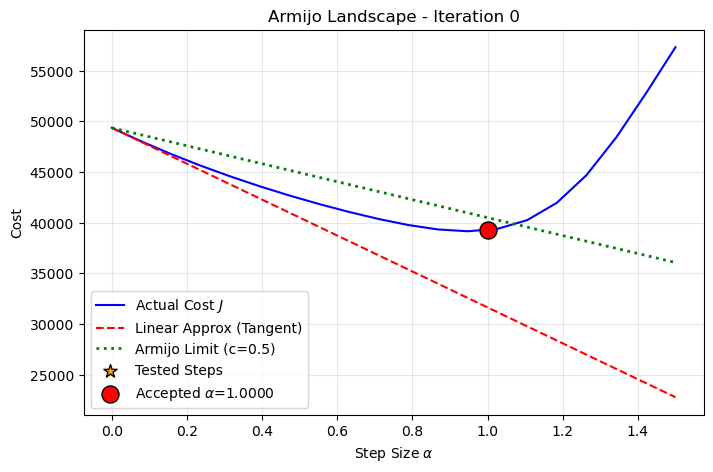

Iter 0: Cost 39249.1049 | Alpha 1.0000 | Slope -17710.86
Generating Armijo Plot for Iteration 1...


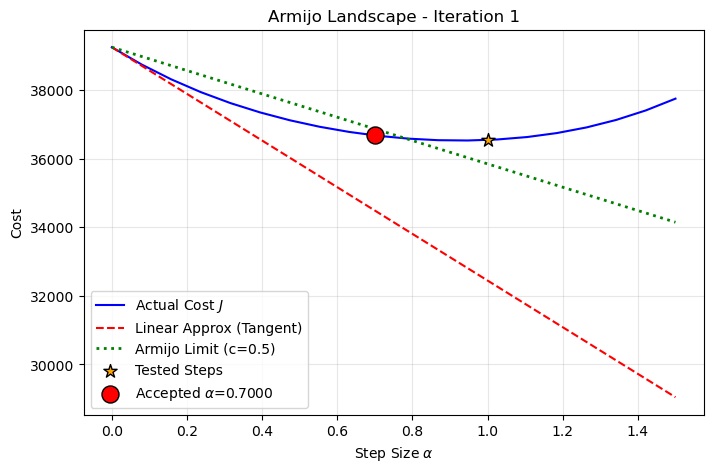

Iter 1: Cost 36677.5748 | Alpha 0.7000 | Slope -6802.73
Iter 2: Cost 32487.9770 | Alpha 1.0000 | Slope -4159.36
Iter 3: Cost 31428.3170 | Alpha 0.3430 | Slope -5346.66
Iter 4: Cost 30513.9409 | Alpha 1.0000 | Slope -1323.27
Iter 5: Cost 29978.8429 | Alpha 1.0000 | Slope -692.94
Iter 6: Cost 29611.2729 | Alpha 1.0000 | Slope -571.23
Iter 7: Cost 29381.3883 | Alpha 0.4900 | Slope -790.89
Iter 8: Cost 29082.2957 | Alpha 1.0000 | Slope -434.65
Iter 9: Cost 28888.1899 | Alpha 0.7000 | Slope -554.16
Generating Armijo Plot for Iteration 10...


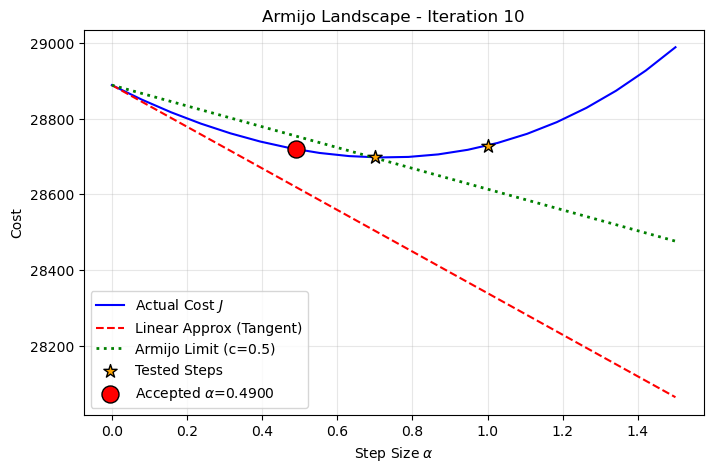

Iter 10: Cost 28718.9214 | Alpha 0.4900 | Slope -549.51
Iter 11: Cost 28479.1053 | Alpha 1.0000 | Slope -321.83
Iter 12: Cost 28309.8758 | Alpha 0.7000 | Slope -390.06
Iter 13: Cost 28153.6060 | Alpha 0.7000 | Slope -372.91
Iter 14: Cost 27999.3052 | Alpha 0.7000 | Slope -381.63
Iter 15: Cost 27854.5646 | Alpha 0.7000 | Slope -367.61
Iter 16: Cost 27708.8849 | Alpha 0.7000 | Slope -386.22
Iter 17: Cost 27571.4497 | Alpha 0.7000 | Slope -374.98
Iter 18: Cost 27448.3293 | Alpha 0.4900 | Slope -402.13
Iter 19: Cost 27260.8786 | Alpha 1.0000 | Slope -251.49
Generating Armijo Plot for Iteration 20...


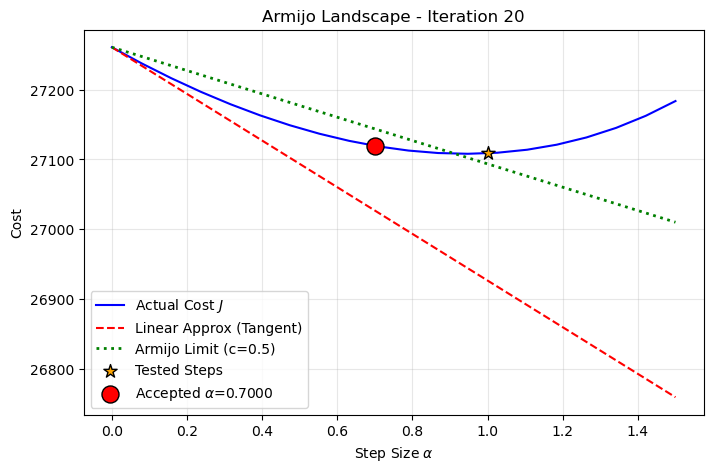

Iter 20: Cost 27119.5307 | Alpha 0.7000 | Slope -334.52
Iter 21: Cost 26984.9114 | Alpha 0.7000 | Slope -328.35
Iter 22: Cost 26847.7631 | Alpha 0.7000 | Slope -357.92
Iter 23: Cost 26716.9827 | Alpha 0.7000 | Slope -354.37
Iter 24: Cost 26598.4227 | Alpha 0.4900 | Slope -392.66
Iter 25: Cost 26419.8701 | Alpha 1.0000 | Slope -244.72
Iter 26: Cost 26285.6184 | Alpha 0.7000 | Slope -337.32
Iter 27: Cost 26161.0731 | Alpha 0.7000 | Slope -330.11
Iter 28: Cost 26051.0873 | Alpha 0.4900 | Slope -365.20
Iter 29: Cost 25886.7575 | Alpha 1.0000 | Slope -228.50
Generating Armijo Plot for Iteration 30...


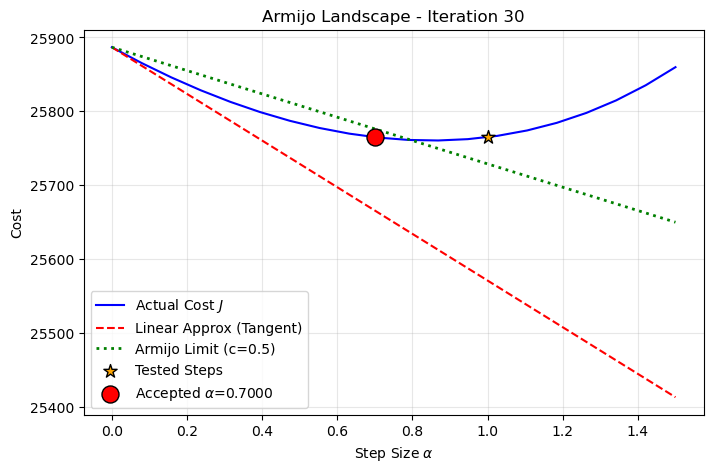

Iter 30: Cost 25765.0317 | Alpha 0.7000 | Slope -315.68
Iter 31: Cost 25654.0358 | Alpha 0.7000 | Slope -305.59
Iter 32: Cost 25554.6077 | Alpha 0.4900 | Slope -342.82
Iter 33: Cost 25410.7293 | Alpha 1.0000 | Slope -207.17
Iter 34: Cost 25304.2447 | Alpha 0.7000 | Slope -296.70
Iter 35: Cost 25216.8277 | Alpha 0.4900 | Slope -286.32
Iter 36: Cost 25086.4799 | Alpha 1.0000 | Slope -203.58
Iter 37: Cost 25003.5241 | Alpha 0.4900 | Slope -273.85
Iter 38: Cost 24882.4803 | Alpha 1.0000 | Slope -194.43
Iter 39: Cost 24803.7912 | Alpha 0.4900 | Slope -265.25
Generating Armijo Plot for Iteration 40...


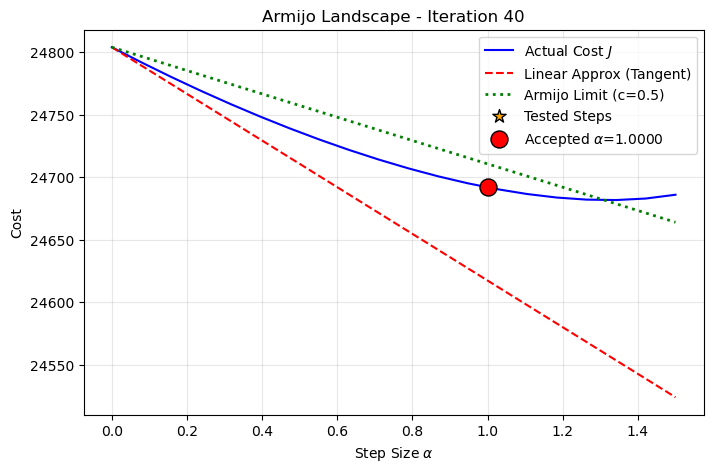

Iter 40: Cost 24691.8231 | Alpha 1.0000 | Slope -186.42
Iter 41: Cost 24616.7352 | Alpha 0.4900 | Slope -259.40
Iter 42: Cost 24513.0507 | Alpha 1.0000 | Slope -180.06
Iter 43: Cost 24440.8686 | Alpha 0.4900 | Slope -256.40
Iter 44: Cost 24344.7264 | Alpha 1.0000 | Slope -175.38
Iter 45: Cost 24274.7357 | Alpha 0.4900 | Slope -256.51
Iter 46: Cost 24185.4745 | Alpha 1.0000 | Slope -172.43
Iter 47: Cost 24116.9483 | Alpha 0.4900 | Slope -260.06
Iter 48: Cost 24046.0201 | Alpha 0.7000 | Slope -171.30
Iter 49: Cost 23978.3036 | Alpha 0.7000 | Slope -159.13


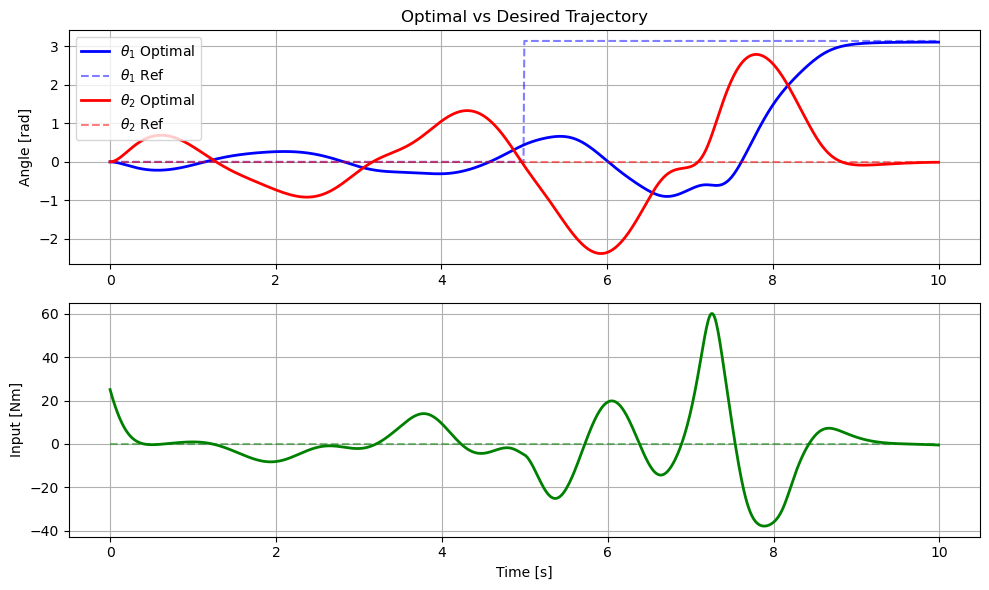

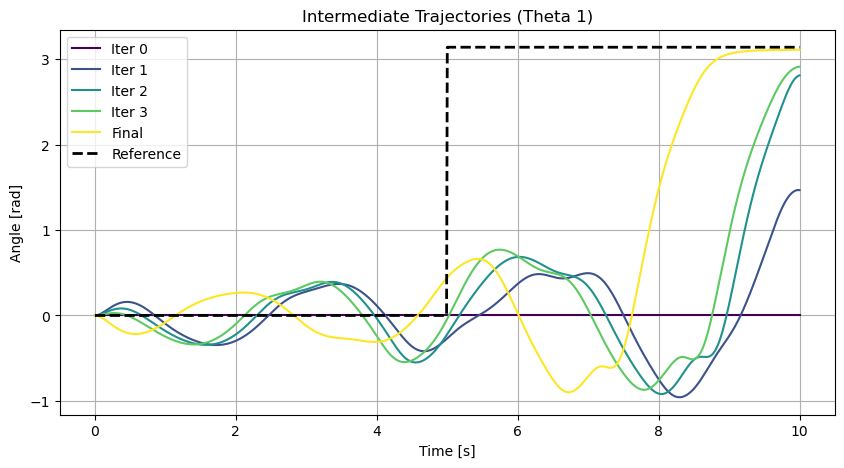

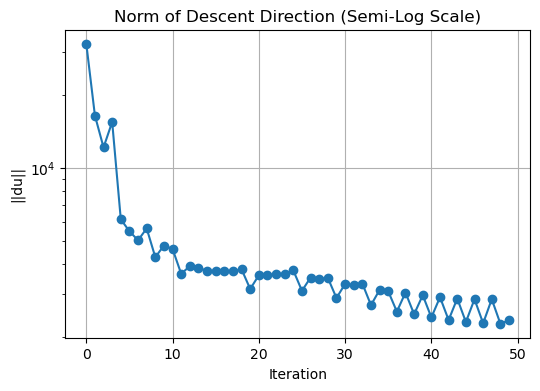

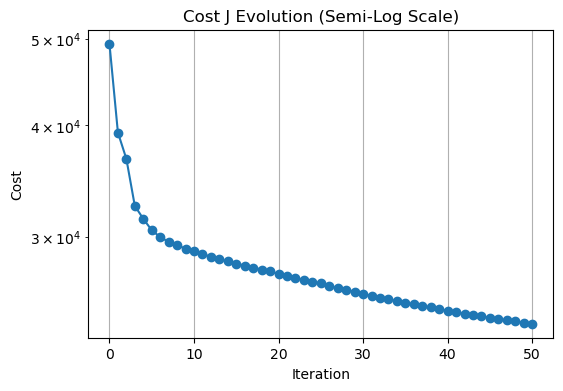

In [4]:
# 1. Setup
robot = Acrobot()
solver = NewtonSolver_Step(robot)

# 2. Equilibria & Ref
solver.compute_equilibria()
solver.generate_step_reference()

# 3. Solve
x_opt, u_opt = solver.solve(max_iters=50)

# --- PLOTTING SECTION ---
time = solver.time_grid

# Plot 1: Optimal vs Desired
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(time, x_opt[:, 0], 'b-', linewidth=2, label=r'$\theta_1$ Optimal')
plt.plot(time, solver.x_ref[:, 0], 'b--', alpha=0.5, label=r'$\theta_1$ Ref')
plt.plot(time, x_opt[:, 1], 'r-', linewidth=2, label=r'$\theta_2$ Optimal')
plt.plot(time, solver.x_ref[:, 1], 'r--', alpha=0.5, label=r'$\theta_2$ Ref')
plt.ylabel('Angle [rad]')
plt.title('Optimal vs Desired Trajectory')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time[:-1], u_opt, 'g-', linewidth=2, label='Torque [Nm]')
plt.plot(time[:-1], solver.u_ref, 'g--', alpha=0.5, label='Torque Ref')
plt.ylabel('Input [Nm]')
plt.xlabel('Time [s]')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Intermediate Trajectories 
plt.figure(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(solver.intermediate_trajs)))
for idx, traj in enumerate(solver.intermediate_trajs):
    label = "Final" if idx == len(solver.intermediate_trajs)-1 else f"Iter {idx}"
    plt.plot(time, traj[:, 0], color=colors[idx], label=label) 
plt.plot(time, solver.x_ref[:, 0], 'k--', linewidth=2, label='Reference')
plt.title('Intermediate Trajectories (Theta 1)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Norm of Descent Direction (Semi-Log Scale)
plt.figure(figsize=(6, 4))
plt.semilogy(solver.descent_norm_history, '-o')
plt.title('Norm of Descent Direction (Semi-Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('||du||')
plt.grid(True)
plt.show()

# Plot 4: Cost Evolution (Semi-Log Scale)
plt.figure(figsize=(6, 4))
plt.semilogy(solver.cost_history, '-o')
plt.title('Cost J Evolution (Semi-Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

## **Task 2 - Trajectory Generation (II)** 

The primary objective of **Task 2** remains identical to **Task 1**: we must calculate the optimal controls and trajectory to move the **Acrobot** from its stable *hanging* equilibrium  
$
x_{eq1}
$
to the unstable *inverted* equilibrium  $x_{eq2}$.

However, while **Task 1** relied on a simple **Step Reference** (holding down, then immediately holding up), **Task 2** requires us to generate a **Smooth Desired Curve**.



### 1. The Conflict in Task 1

In **Task 1**, we used a flat reference $x_{ref}$ = 0
for the first half of the maneuver. This created a mathematical conflict:

- **The Physics**  
  To reach the top, the underactuated robot must swing back and force to pump energy into the system. It physically cannot go straight up.

- **The Optimization**  
  The cost function $J$ penalizes the robot for every radian it deviates from $0$. Effectively, the cost function is *“yelling”* at the robot to stay still, while the physics requires it to move.

- **Result**  
  The solver has to fight this penalty to find a solution, often leading to slower convergence or higher control efforts.






### 2. The Solution: A *Physically Superior* Reference

In **Task 2**, we introduce a **Natural Reference Generator**. Instead of a flat line, we design a reference curve that anticipates the robot’s need to swing.

By adding oscillations to the reference curve, we are effectively telling the **Cost Function**:

> “It is okay to swing here. In fact, I want you to swing.”

This approach aligns the mathematical reference with the natural *energy-pumping* dynamics of the Acrobot, reducing the conflict between the objective function and the constraints.






### 3. Implementation Strategy

We construct the reference trajectory in two distinct phases:

#### Phase 1: Energy Pumping
- We implement **sinusoidal oscillations** for $\theta_1$ and $\theta_2$ during the first half of the trajectory.
- The frequency is tuned to mimic the natural frequency of the pendulum:
  $
  \omega \approx \sqrt{\frac{g}{l}}
  $
- This encourages resonance and efficient energy injection into the system.

#### Phase 2: The Swing-Up
- Instead of a sharp step, we use a **Sigmoid Function** (smooth logistic curve) to transition the target states.
- The reference smoothly moves from the oscillating bottom configuration to the final upright equilibrium $x_{eq2}$.

In [3]:
class NewtonSolver_Smooth:
    def __init__(self, robot):
        self.robot = robot
        self.dt = 0.01
        self.T_horizon = 10.0  # Total time for swing-up
        self.N = int(self.T_horizon / self.dt)
        
       
        # Q: State penalty. High penalty on angles to force tracking.
        self.Q = np.zeros((4, 4))
        self.Q[0,0] = 10.0   # Theta1
        self.Q[1,1] = 10.0   # Theta2
        self.Q[2,2] = 0.1    # Velocity 1
        self.Q[3,3] = 0.1    # Velocity 2
        
        # R: Control penalty. 
        # Lower R = More aggressive torque allowed.
        self.R = np.eye(1) * 0.01 
        
        # Q_final: Terminal cost. Very high to ensure we land on the target.
        self.Q_final = np.zeros((4, 4))
        self.Q_final[0,0] = 5000.0
        self.Q_final[1,1] = 5000.0
        self.Q_final[2,2] = 1000.0
        self.Q_final[3,3] = 1000.0

        # Storage for plots
        self.cost_history = []
        self.descent_norm_history = []
        self.armijo_alphas = []
        self.intermediate_trajs = [] # To store x trajectories 






    def compute_equilibria(self):
        """
        Solves f(x, 0) = 0 using root finding.
        """
        def residuals(q_guess):
            # Form full state with 0 velocity
            x_test = np.array([q_guess[0], q_guess[1], 0.0, 0.0])
            u_zero = np.array([0.0])
            # Return accelerations (must be 0)
            return self.robot.continuous_dynamics(x_test, u_zero)[2:]

        # 1. Down Equilibrium
        q_down = fsolve(residuals, [0.0, 0.0])
        self.x_eq1 = np.array([q_down[0], q_down[1], 0.0, 0.0])
        
        # 2. Up Equilibrium (Inverted)
        q_up = fsolve(residuals, [np.pi, 0.0])
        self.x_eq2 = np.array([q_up[0], q_up[1], 0.0, 0.0])
        
        # Verify inputs required
        # u_eq2 should be ~0 based on physics, but let's calculate it to be precise
        # Inverting dynamics: tau = M*0 + C*0 + G
        # At zero velocity, tau = G(q)
        # We only actuate the second joint, so we check G[1]
        _, _, G_up, _ = self.robot.get_matrices(self.x_eq2)
        self.u_eq2 = G_up[1] # Should be effectively 0
        
        print(f"Equilibrium Down: {self.x_eq1}")
        print(f"Equilibrium Up:   {self.x_eq2}")
        print(f"Torque req at Up: {self.u_eq2}") # likely approx 1e-15 (zero)


    
   
    def generate_natural_reference(self):
        """
        Generates a "Physically Inspired" reference.
        """
        self.time_grid = np.linspace(0, self.T_horizon, self.N + 1)
        self.x_ref = np.zeros((self.N + 1, 4))
        self.u_ref = np.zeros((self.N, 1))
        
        # Parameters for the "Natural" motion
        t_switch = self.T_horizon / 1.5  # Time to start the main lift
        
        # 1. Oscillation Parameters
        pump_freq = 3.0  
        pump_amp_1 = 0.5  # Amplitude for Theta 1 (Links)
        pump_amp_2 = 1.0  # Amplitude for Theta 2 (Hips)
        
        # 2. Sigmoid Parameters (The Rise)
        k_rise = 3.0 # Steepness of the lift
        
        for i in range(self.N + 1):
            t = self.time_grid[i]
            
            # --- COMPONENT A: The Pumping (Oscillation) ---
            # We use a window function so it only happens in the first half
            # 'fade_out' goes from 1 to 0 around t_switch
            fade_out = 1.0 / (1.0 + np.exp(5.0 * (t - t_switch)))
            
            # Sine wave for pumping
            # Note: Theta 2 usually moves opposite to Theta 1 to pump energy
            osc_1 = pump_amp_1 * np.sin(pump_freq * t) * fade_out
            osc_2 = -pump_amp_2 * np.sin(pump_freq * t) * fade_out # Counter-phase
            
            # --- COMPONENT B: The Rise (Sigmoid) ---
            # 'fade_in' goes from 0 to 1 around t_switch
            fade_in = 1.0 / (1.0 + np.exp(-k_rise * (t - t_switch)))
            
            # Target positions
            target_1 = self.x_eq1[0] * (1-fade_in) + self.x_eq2[0] * fade_in
            target_2 = self.x_eq1[1] * (1-fade_in) + self.x_eq2[1] * fade_in
            
            # --- COMBINE ---
            # Total Ref = Oscillation (early) + Target Rise (late)
            self.x_ref[i, 0] = osc_1 + target_1
            self.x_ref[i, 1] = osc_2 + target_2
           

        return self.x_ref, self.u_ref
    







    def get_derivatives_fd(self, x, u):
        """
        Finite Difference calculation of Jacobians A, B.
        """
        eps = 1e-6
        nx, nu = 4, 1
        A = np.zeros((nx, nx)) # shape (4,4)
        B = np.zeros((nx, nu)) # shape (4,1)
        
        # Center point 
        f0 = self.robot.discrete_step_rk4(x, u, self.dt)
        
        for i in range(nx):
            x_inc = x.copy(); x_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x_inc, u, self.dt)
            A[:, i] = (f_inc - f0) / eps
            
        for i in range(nu):
            u_inc = u.copy(); u_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x, u_inc, self.dt)
            B[:, i] = (f_inc - f0) / eps
            
        return A, B
    






    def cost_func(self, x_traj, u_traj):
        """ Total cost J calculation """
        J = 0
        # Sum of stage costs
        for i in range(self.N):
            x_err = x_traj[i] - self.x_ref[i]
            u_err = u_traj[i] - self.u_ref[i]
            J += 0.5 * (x_err.T @ self.Q @ x_err + u_err.T @ self.R @ u_err)
            
        # Terminal cost
        x_terminal_err = x_traj[-1] - self.x_ref[-1]
        J += 0.5 * x_terminal_err.T @ self.Q_final @ x_terminal_err

        return J
    





    def solve(self, max_iters=50):
        
        # 1) Initialization
        u = np.zeros((self.N, 1)) 
        x_traj = np.zeros((self.N + 1, 4))
        x_traj[0] = self.x_eq1  # Set up the initial state x_0
        
        # Initial Rollout
        for i in range(self.N):
            x_traj[i+1] = self.robot.discrete_step_rk4(x_traj[i], u[i], self.dt)
            
        initial_cost = self.cost_func(x_traj, u)
        self.cost_history.append(initial_cost)
        self.intermediate_trajs.append(x_traj.copy())
        
        print(f"Iter 0: Cost {initial_cost:.4f}")





        # Armijo Parameters 
        cc = 0.5
        beta = 0.7
        max_steps_armijo = 20

        # 2) Newton Loop (Backward Pass)
        for it in range(max_iters):
             
            # Nomenclature:
            # P_t: Quadratic Cost-to-Go (Matrix)
            # p_t: Linear Cost-to-Go (Vector)
            # K_t: Feedback Gain
            # sigma_t: Feedforward Correction

            # 1. Initialize Cost-to-Go at Terminal State (t=T)
            dx_terminal = x_traj[-1] - self.x_ref[-1] 
            p = self.Q_final @ dx_terminal   # p_T = Q_T * (x_T - x_ref)
            P = self.Q_final                 # P_T = Q_T
            
            # Storage for computed gains
            sigma_vec = np.zeros((self.N, 1))
            K_gains = np.zeros((self.N, 1, 4))
            
            expected_slope = 0.0
            descent_norm = 0.0
            
            for i in range(self.N - 1, -1, -1):
                # A. Linearize Dynamics (A_t, B_t)
                A_t, B_t = self.get_derivatives_fd(x_traj[i], u[i])
                
                # B. Approximate Cost (Gradient q_t, r_t and Hessian Q_t, R_t)

                # Compute state and control errors
                dx = x_traj[i] - self.x_ref[i]
                du = u[i] - self.u_ref[i]
                
                q_t = self.Q @ dx  # Gradient w.r.t state
                r_t = self.R @ du  # Gradient w.r.t control
                
                # C. Compute Terms for Riccati Equation
                # The term to invert: (R_t + B_t^T * P_{t+1} * B_t)
                # We call this S_mat (often denoted as Q_uu in DDP)
                S_mat = self.R + B_t.T @ P @ B_t
                S_inv = np.linalg.inv(S_mat + np.eye(1)*1e-6) # Regularization

                # D. Compute Gains
                # K^* = -S_inv * (B^T P A)
                # sigma^* = -S_inv * (r_t + B^T p)
                
                K_t = -S_inv @ (B_t.T @ P @ A_t)
                sigma_t = -S_inv @ (r_t + B_t.T @ p)
                
                # Store gains
                sigma_vec[i] = sigma_t
                K_gains[i] = K_t
                
                # E. Update Cost-to-Go (Riccati Recursion)
                # P_t = Q_t + A^T P A - K^T S K
                # p_t = q_t + A^T p - K^T S sigma
           
                term_quad = K_t.T @ S_mat @ K_t
                P = self.Q + A_t.T @ P @ A_t - term_quad
                
                term_lin = K_t.T @ S_mat @ sigma_t
                p = q_t + A_t.T @ p - term_lin
                
                # F. Accumulate Slope for Armijo
                # slope = r_t^T * sigma + p_{next}^T * B * sigma
                # Easier way: gradient_u^T * sigma
                # gradient_u = r_t + B^T p
                gradient_u = r_t + B_t.T @ p
                expected_slope += (gradient_u.T @ sigma_t).item()
                descent_norm += np.linalg.norm(sigma_t)

            self.descent_norm_history.append(descent_norm)

            # --- Forward Pass (Armijo Search with Closed-Loop Rollout) ---
            alpha = 1.0 
            accepted = False
            best_x_new = None
            best_u_new = None
            best_cost = float('inf') 
            
            alphas_tested = []
            costs_tested = []

            for ii in range(max_steps_armijo):
                x_new = np.zeros_like(x_traj); x_new[0] = x_traj[0]
                u_new = np.zeros_like(u)
                
                for i in range(self.N):
                    # Deviation from nominal trajectory
                    dx_deviation = x_new[i] - x_traj[i]
                    
                    # Closed-Loop Update: u = u_bar + alpha*sigma + K*dx
                    du = alpha * sigma_vec[i] + K_gains[i] @ dx_deviation
                    
                    u_new[i] = u[i] + du
                    x_new[i+1] = self.robot.discrete_step_rk4(x_new[i], u_new[i], self.dt)
                
                current_cost = self.cost_func(x_new, u_new)
                alphas_tested.append(alpha)
                costs_tested.append(current_cost)

                # Armijo Condition
                armijo_threshold = self.cost_history[-1] + cc * alpha * expected_slope
                
                if current_cost <= armijo_threshold:
                    best_x_new = x_new
                    best_u_new = u_new
                    best_cost = current_cost
                    accepted = True
                    break 
                else:
                    alpha *= beta 
            
            # --- PLOTTING: Armijo Landscape ---
            if it < 2 or it % 10 == 0:
                print(f"Generating Armijo Plot for Iteration {it}...")
                
                # Generate a smooth curve for visualization (strictly for plotting)
                test_alphas = np.linspace(0, 1.5, 20) 
                costs_landscape = []
                
                for alpha_val in test_alphas:
                    x_temp = np.zeros_like(x_traj); x_temp[0] = x_traj[0]
                    u_temp = np.zeros_like(u)
                    for i in range(self.N):
                        dx_loc = x_temp[i] - x_traj[i]
                        u_val = u[i] + alpha_val * sigma_vec[i] + K_gains[i] @ dx_loc
                        u_temp[i] = u_val
                        x_temp[i+1] = self.robot.discrete_step_rk4(x_temp[i], u_val, self.dt)
                    costs_landscape.append(self.cost_func(x_temp, u_temp))
                
                plt.figure(figsize=(8, 5))
                # 1. Actual Cost Curve
                plt.plot(test_alphas, costs_landscape, 'b-', label='Actual Cost $J$')
                
                # 2. Linear Approximation (Tangent)
                linear_approx = [self.cost_history[-1] + a * expected_slope for a in test_alphas]
                plt.plot(test_alphas, linear_approx, 'r--', label='Linear Approx (Tangent)')
                
                # 3. Armijo Condition Line
                armijo_line = [self.cost_history[-1] + a * cc * expected_slope for a in test_alphas]
                plt.plot(test_alphas, armijo_line, 'g:', linewidth=2, label=f'Armijo Limit (c={cc})')
                
                # 4. Tested Points
                plt.scatter(alphas_tested, costs_tested, marker='*', s=100, color='orange', 
                            edgecolor='black', zorder=5, label='Tested Steps')
                
                # 5. Accepted Point
                if accepted:
                    plt.scatter(alpha, best_cost, marker='o', s=150, color='red', 
                                edgecolor='black', zorder=6, label=f'Accepted $\\alpha$={alpha:.4f}')
                
                plt.title(f'Armijo Landscape - Iteration {it}')
                plt.xlabel('Step Size $\\alpha$')
                plt.ylabel('Cost')
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.show()

            self.armijo_alphas.append(alpha)
            
            if accepted:
                self.cost_history.append(best_cost)
                x_traj = best_x_new
                u = best_u_new
                print(f"Iter {it}: Cost {best_cost:.4f} | Alpha {alpha:.4f} | Slope {expected_slope:.2f}")
                
                if it in [1, 5, 10]: 
                    self.intermediate_trajs.append(x_traj.copy())
            
        self.intermediate_trajs.append(x_traj.copy())
        return x_traj, u

Equilibrium Down: [0. 0. 0. 0.]
Equilibrium Up:   [3.14159265 0.         0.         0.        ]
Torque req at Up: [1.80206776e-15]
Iter 0: Cost 41574.9116
Generating Armijo Plot for Iteration 0...


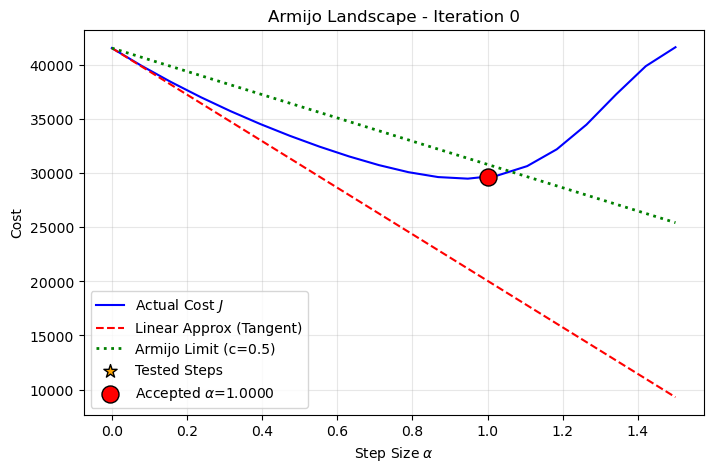

Iter 0: Cost 29637.8117 | Alpha 1.0000 | Slope -21522.02
Generating Armijo Plot for Iteration 1...


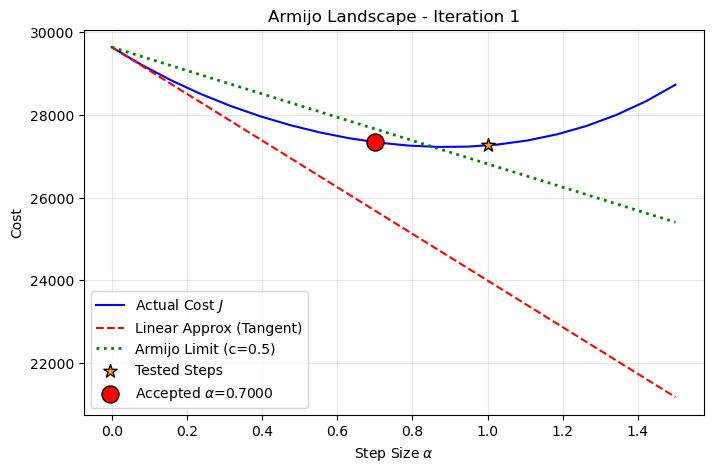

Iter 1: Cost 27341.1020 | Alpha 0.7000 | Slope -5645.82
Iter 2: Cost 23715.4042 | Alpha 1.0000 | Slope -3374.91
Iter 3: Cost 22518.4225 | Alpha 0.3430 | Slope -6177.19
Iter 4: Cost 21633.9428 | Alpha 1.0000 | Slope -1446.92
Iter 5: Cost 21239.4180 | Alpha 1.0000 | Slope -520.32
Iter 6: Cost 20968.6387 | Alpha 1.0000 | Slope -353.01
Iter 7: Cost 20809.3951 | Alpha 0.7000 | Slope -361.24
Iter 8: Cost 20671.0878 | Alpha 0.7000 | Slope -339.14
Iter 9: Cost 20549.9346 | Alpha 0.7000 | Slope -303.37
Generating Armijo Plot for Iteration 10...


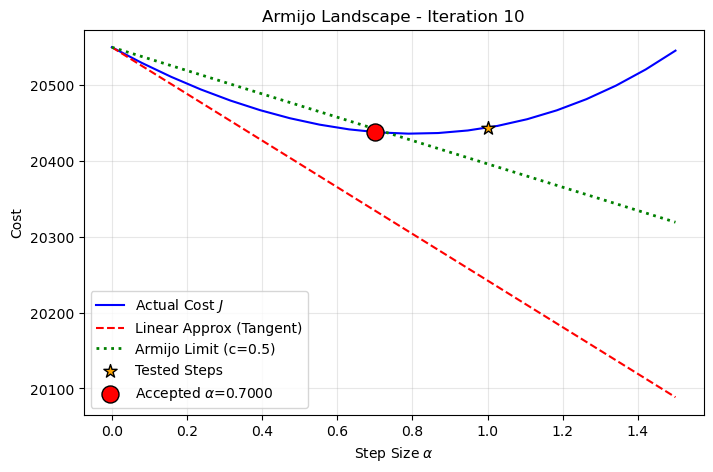

Iter 10: Cost 20437.9931 | Alpha 0.7000 | Slope -307.69
Iter 11: Cost 20338.0617 | Alpha 0.7000 | Slope -275.59
Iter 12: Cost 20253.6354 | Alpha 0.4900 | Slope -291.11
Iter 13: Cost 20132.0935 | Alpha 1.0000 | Slope -168.28
Iter 14: Cost 20048.8486 | Alpha 0.7000 | Slope -214.96
Iter 15: Cost 19971.8894 | Alpha 0.7000 | Slope -193.43
Iter 16: Cost 19908.4641 | Alpha 0.4900 | Slope -214.60
Iter 17: Cost 19809.8710 | Alpha 1.0000 | Slope -133.86
Iter 18: Cost 19740.8680 | Alpha 0.7000 | Slope -173.26
Iter 19: Cost 19675.3059 | Alpha 0.7000 | Slope -156.35
Generating Armijo Plot for Iteration 20...


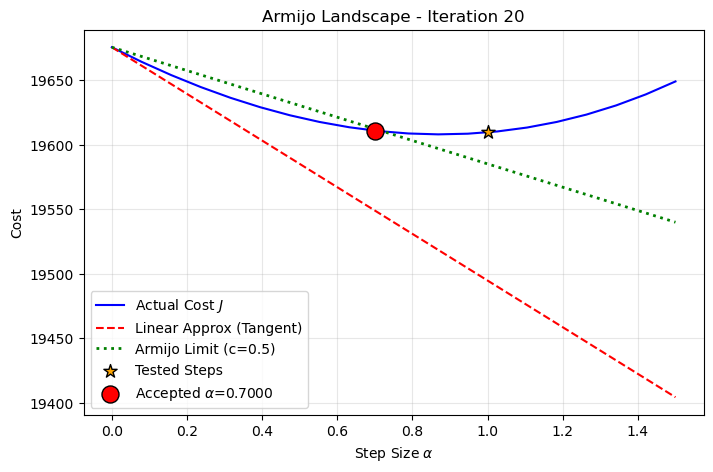

Iter 20: Cost 19610.7338 | Alpha 0.7000 | Slope -180.57
Iter 21: Cost 19548.5095 | Alpha 0.7000 | Slope -163.53
Iter 22: Cost 19493.9769 | Alpha 0.4900 | Slope -194.95
Iter 23: Cost 19408.1128 | Alpha 1.0000 | Slope -119.55
Iter 24: Cost 19343.9669 | Alpha 0.7000 | Slope -171.05
Iter 25: Cost 19279.7659 | Alpha 0.7000 | Slope -159.14
Iter 26: Cost 19223.1490 | Alpha 0.4900 | Slope -195.45
Iter 27: Cost 19127.1065 | Alpha 1.0000 | Slope -128.43
Iter 28: Cost 19051.6978 | Alpha 0.7000 | Slope -186.71
Iter 29: Cost 18972.9415 | Alpha 0.7000 | Slope -180.62
Generating Armijo Plot for Iteration 30...


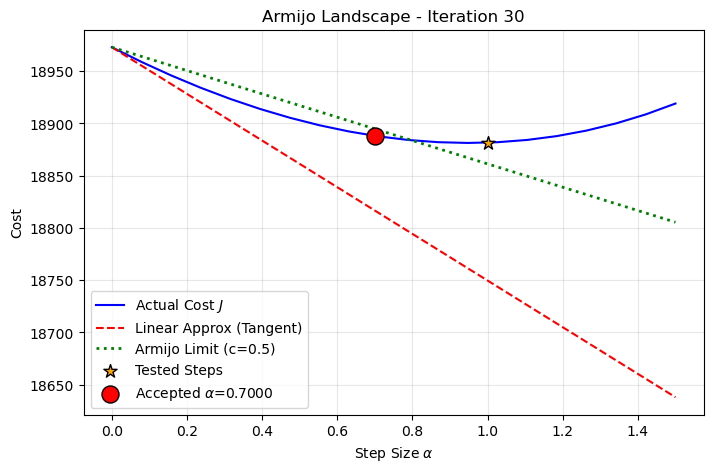

Iter 30: Cost 18888.1405 | Alpha 0.7000 | Slope -223.27
Iter 31: Cost 18798.9373 | Alpha 0.7000 | Slope -217.96
Iter 32: Cost 18702.6813 | Alpha 0.7000 | Slope -268.81
Iter 33: Cost 18603.1409 | Alpha 0.7000 | Slope -262.02
Iter 34: Cost 18511.2612 | Alpha 0.4900 | Slope -317.04
Iter 35: Cost 18362.6266 | Alpha 1.0000 | Slope -202.05
Iter 36: Cost 18250.5496 | Alpha 0.7000 | Slope -283.16
Iter 37: Cost 18143.9963 | Alpha 0.7000 | Slope -264.60
Iter 38: Cost 18039.4627 | Alpha 0.7000 | Slope -296.85
Iter 39: Cost 17943.0297 | Alpha 0.7000 | Slope -269.59
Generating Armijo Plot for Iteration 40...


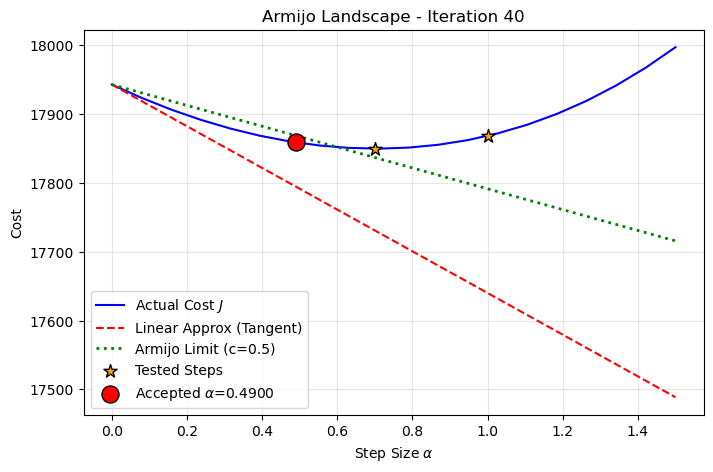

Iter 40: Cost 17858.9676 | Alpha 0.4900 | Slope -302.94
Iter 41: Cost 17739.8584 | Alpha 1.0000 | Slope -172.03
Iter 42: Cost 17657.5412 | Alpha 0.7000 | Slope -231.23
Iter 43: Cost 17583.7707 | Alpha 0.7000 | Slope -201.04
Iter 44: Cost 17521.4223 | Alpha 0.4900 | Slope -226.65
Iter 45: Cost 17431.7055 | Alpha 1.0000 | Slope -127.95
Iter 46: Cost 17369.6233 | Alpha 0.7000 | Slope -173.35
Iter 47: Cost 17312.2301 | Alpha 0.7000 | Slope -147.30
Iter 48: Cost 17264.2260 | Alpha 0.4900 | Slope -172.05
Iter 49: Cost 17189.8005 | Alpha 1.0000 | Slope -101.38


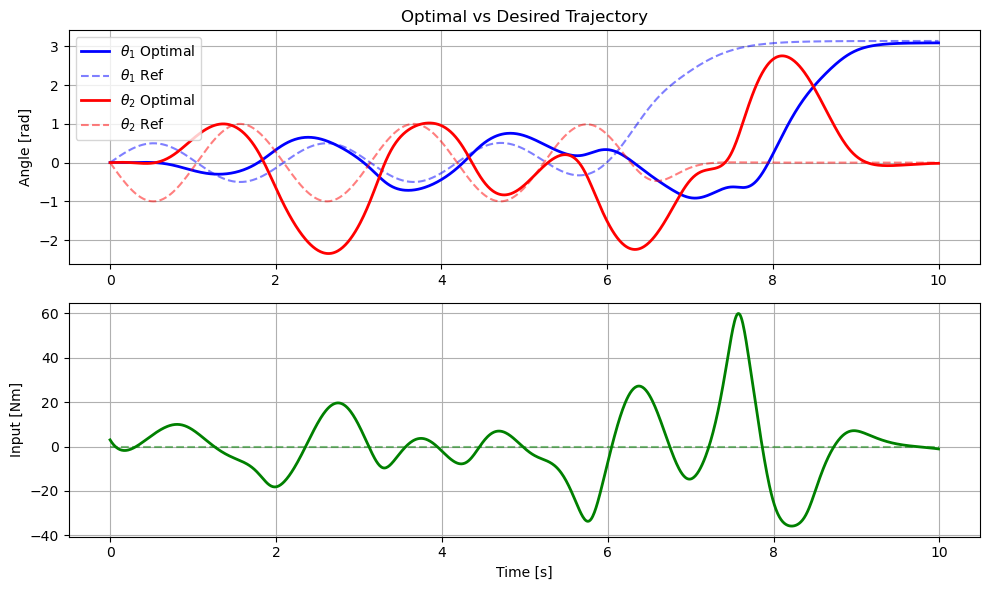

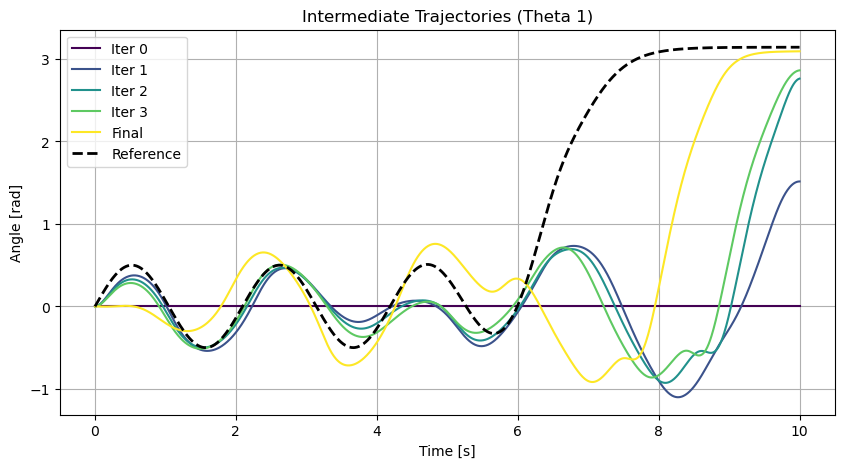

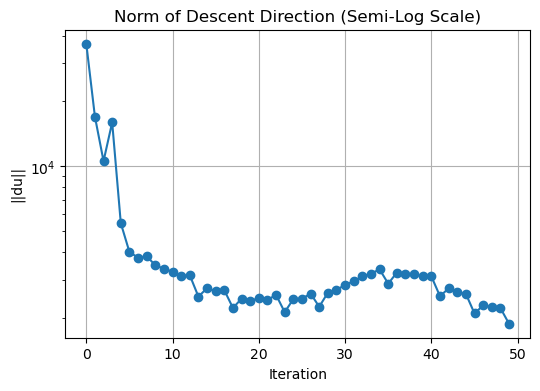

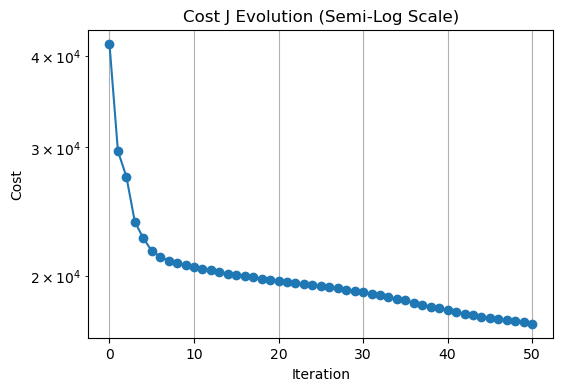

In [4]:
# 1. Setup
robot = Acrobot()
solver = NewtonSolver_Smooth(robot)

# 2. Equilibria & Ref
solver.compute_equilibria()
solver.generate_natural_reference()

# 3. Solve
x_opt, u_opt = solver.solve(max_iters=50)

# --- PLOTTING SECTION ---
time = solver.time_grid

# Plot 1: Optimal vs Desired
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(time, x_opt[:, 0], 'b-', linewidth=2, label=r'$\theta_1$ Optimal')
plt.plot(time, solver.x_ref[:, 0], 'b--', alpha=0.5, label=r'$\theta_1$ Ref')
plt.plot(time, x_opt[:, 1], 'r-', linewidth=2, label=r'$\theta_2$ Optimal')
plt.plot(time, solver.x_ref[:, 1], 'r--', alpha=0.5, label=r'$\theta_2$ Ref')
plt.ylabel('Angle [rad]')
plt.title('Optimal vs Desired Trajectory')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time[:-1], u_opt, 'g-', linewidth=2, label='Torque [Nm]')
plt.plot(time[:-1], solver.u_ref, 'g--', alpha=0.5, label='Torque Ref')
plt.ylabel('Input [Nm]')
plt.xlabel('Time [s]')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Intermediate Trajectories (The "Learning" Process)
plt.figure(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, len(solver.intermediate_trajs)))
for idx, traj in enumerate(solver.intermediate_trajs):
    label = "Final" if idx == len(solver.intermediate_trajs)-1 else f"Iter {idx}"
    plt.plot(time, traj[:, 0], color=colors[idx], label=label) # Plotting Theta1 only for clarity
plt.plot(time, solver.x_ref[:, 0], 'k--', linewidth=2, label='Reference')
plt.title('Intermediate Trajectories (Theta 1)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.legend()
plt.grid(True)
plt.show()


# Plot 3: Norm of Descent Direction (Semi-Log Scale)
plt.figure(figsize=(6, 4))
plt.semilogy(solver.descent_norm_history, '-o')
plt.title('Norm of Descent Direction (Semi-Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('||du||')
plt.grid(True)
plt.show()

# Plot 4: Cost Evolution (Semi-Log Scale)
plt.figure(figsize=(6, 4))
plt.semilogy(solver.cost_history, '-o')
plt.title('Cost J Evolution (Semi-Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

## **Task 3: Trajectory Tracking via standard LQR**

This section represents a distinct phase from the previous trajectory generation.

In **Task 2**, we focused on **planning** — generating a feasible, optimal path $(x_{gen}, u_{gen})$ for the robot to follow.  
In **Task 3**, we shift focus to **control** — designing a feedback regulator that ensures the robot actually stays on that path, even in the presence of disturbances or modeling errors.


We employ a **Time-Varying Linear Quadratic Regulator (TV-LQR)**.  
This algorithm utilizes the optimal trajectory generated previously to compute a sequence of optimal feedback gains $K_t$. These gains allow us to update the control input in real time based on the tracking error, effectively *pulling* the system back to the reference.



### 1. The LQR Tracker Class

The `LQRTracker` class implements this logic. It does **not** solve for a new trajectory; rather, it calculates how to stabilize the existing one.

#### Cost Matrices ($Q_{reg}, R_{reg}$)

- $Q_{reg}$: Penalizes deviations from the reference path (tracking error).  

- $R_{reg}$: Penalizes the control effort used for corrections.



### 2. Linearization (`get_derivatives_fd`)

To apply LQR to our nonlinear robot model, we approximate the dynamics using a local linearization.  
We use the **finite difference** method to compute the Jacobians $A_t$ and $B_t$, as done previously during trajectory generation.

Crucially, the dynamics are linearized about the optimal (feasible) trajectory $(x_{\text{gen}}, u_{\text{gen}})$ at each time step (practical necessity).  
This produces a **time-varying linear approximation** of the system that is locally valid for small deviations from the reference trajectory.




### 3. Computing Gains (`compute_gains`)

This method performs the **Backward Pass** to solve the Time-Varying Riccati Equation.

- We iterate backwards from the final time $T$ to $0$.
- At each step $t$, we compute the optimal feedback gain $K_t$:

$$
K_t = \left(R + B_t^T P_{t+1} B_t\right)^{-1} B_t^T P_{t+1} A_t
$$

- We then update the **Cost-to-Go** matrix $P_t$, which represents the cost of future errors, using the Difference Riccati Equation (DRE).

This process pre-computes the optimal reaction strategy for the entire time horizon.


### 4. Closed-Loop Simulation (`simulate_tracking`)

Here, we validate the controller by simulating the system with an initial perturbation.

#### **Control Law (Newton)**

$$
u_{applied}(t) = u_{gen}(t) - K_t \cdot \left(x_{real}(t) - x_{gen}(t)\right)
$$

This feedback term actively corrects the error.  
If the robot drifts left, the gain $K_t$ computes exactly how much torque is needed to push it back to the right.


In [8]:
class LQRTracker:
    def __init__(self, robot, x_gen, u_gen, dt):
        self.robot = robot
        self.x_gen = x_gen
        self.u_gen = u_gen
        self.dt = dt
        self.N = len(u_gen)
        
        # --- LQR Cost Matrices  ---
        self.Q_reg = np.diag([100.0, 100.0, 10.0, 10.0]) 
        self.R_reg = np.diag([5.0]) 
        self.Q_reg_final = np.diag([5000.0, 5000.0, 2500.0, 2500.0])





    def get_derivatives_fd(self, x, u): # Linearization of the non-linear dynamics
        """
        Finite Difference calculation of Jacobians A, B.
        """
        eps = 1e-6
        nx, nu = 4, 1
        A = np.zeros((nx, nx)) 
        B = np.zeros((nx, nu)) 
        
        # Center point 
        f0 = self.robot.discrete_step_rk4(x, u, self.dt)
        
        for i in range(nx):
            x_inc = x.copy(); x_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x_inc, u, self.dt)
            A[:, i] = (f_inc - f0) / eps
            
        for i in range(nu):
            u_inc = u.copy(); u_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x, u_inc, self.dt)
            B[:, i] = (f_inc - f0) / eps
            
        return A, B



    

    def compute_gains(self):
        """
        Solves the Time-Varying Riccati Equation backwards.
        Returns the sequence of Feedback Gains K.
        """
        print("Computing LQR Gains...")
        
        # Initialize Cost-to-Go P with terminal cost
        P = self.Q_reg_final # P_T = Q_reg_T
        
        # Storage for gains
        self.K_gains = np.zeros((self.N, 1, 4)) 
        
        # Backward Pass
        for t in range(self.N - 1, -1, -1):
            # 1. Linearize around the OPTIMAL trajectory from Task 2
            x_t = self.x_gen[t]
            u_t = self.u_gen[t]
            A_t, B_t = self.get_derivatives_fd(x_t, u_t)
            
            # 2. Compute Gain K_t
            # K = inv(R + B'PB) * B'PA
            # Intermediate term: S = R + B'PB
            S = self.R_reg + B_t.T @ P @ B_t
            S_inv = np.linalg.inv(S)
            
            K_t = S_inv @ (B_t.T @ P @ A_t)
            self.K_gains[t] = K_t
            
            # 3. Update P_t (Riccati Equation)
            # P_new = Q + A'PA - A'PB * K
            term1 = A_t.T @ P @ A_t
            term2 = A_t.T @ P @ B_t @ K_t

            # Here we update the cost-to-go P to propagate it to the next time step (Backward Pass)
            P = self.Q_reg + term1 - term2
            
        print("LQR Gains Computed.")
        return self.K_gains





    def simulate_tracking(self, initial_perturbation):
        """
        Simulates the closed-loop system with a disturbed initial condition.
        x_0 = x_gen_0 + perturbation
        """
        x_real = np.zeros_like(self.x_gen)
        u_real = np.zeros_like(self.u_gen)
        
        # Apply perturbation to start
        x_real[0] = self.x_gen[0] + initial_perturbation
        
        print(f"Starting Tracking with Perturbation: {initial_perturbation}")
        
        for t in range(self.N):
            # 1. Calculate Error
            error = x_real[t] - self.x_gen[t]
            
            # 2. Apply Control Law: u = u_ff - K*error
            # Feedforward (u_gen) + Feedback (-K*error)
            feedback_term = -self.K_gains[t] @ error
            u_applied = self.u_gen[t] + feedback_term # We properly modify the state controller to fix the problem caused by the perturbation

            
            u_real[t] = u_applied
            
            # 3. Step Physics
            x_real[t+1] = self.robot.discrete_step_rk4(x_real[t], u_applied, self.dt) # Output of the real system
            
        return x_real, u_real

Computing LQR Gains...
LQR Gains Computed.
Starting Tracking with Perturbation: [ 0.5 -0.3  0.   0. ]


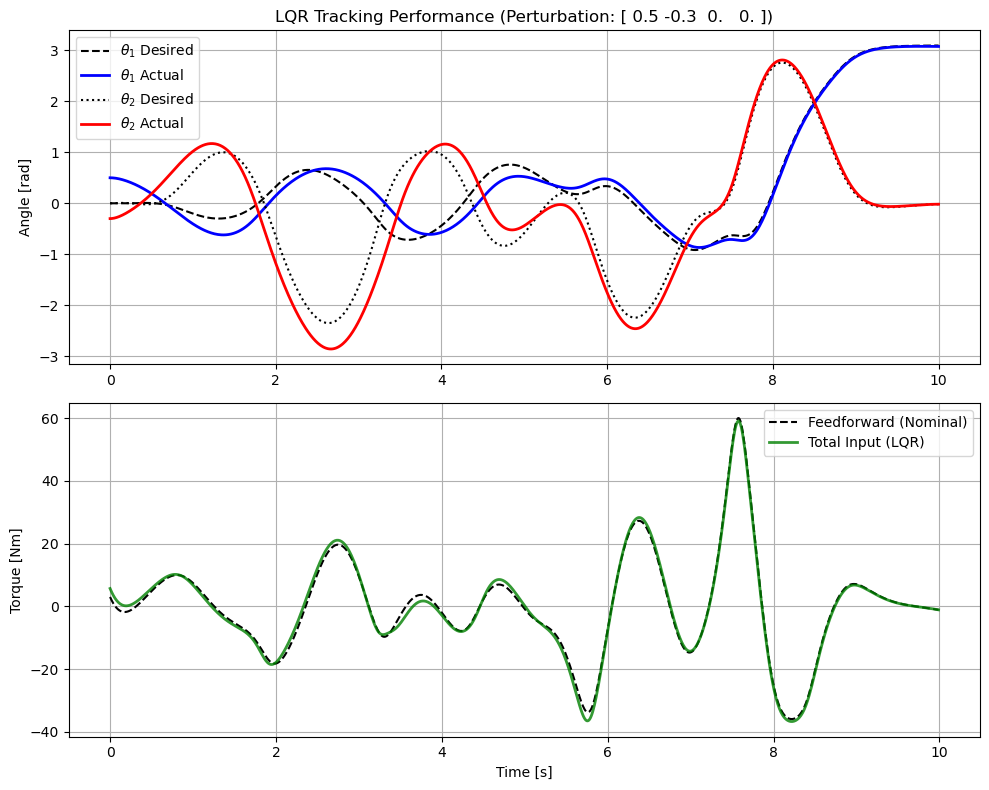

Starting Tracking with Perturbation: [ 0.5 -0.3  0.   0. ]


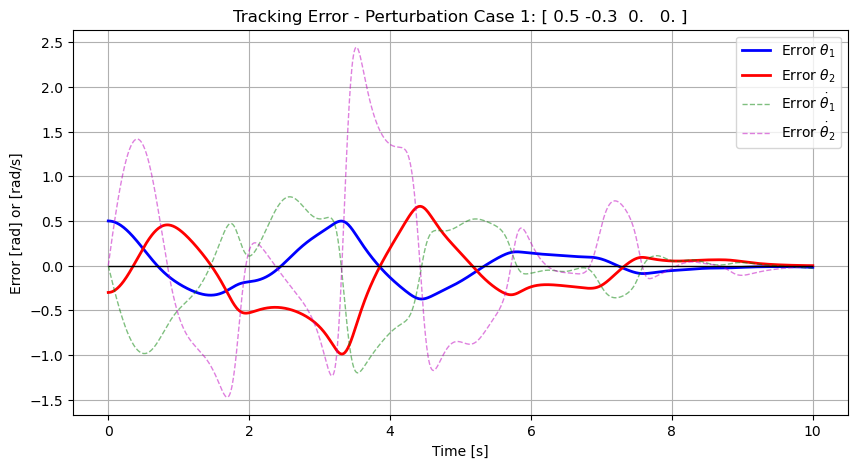

Starting Tracking with Perturbation: [ 0.   0.   0.5 -0.5]


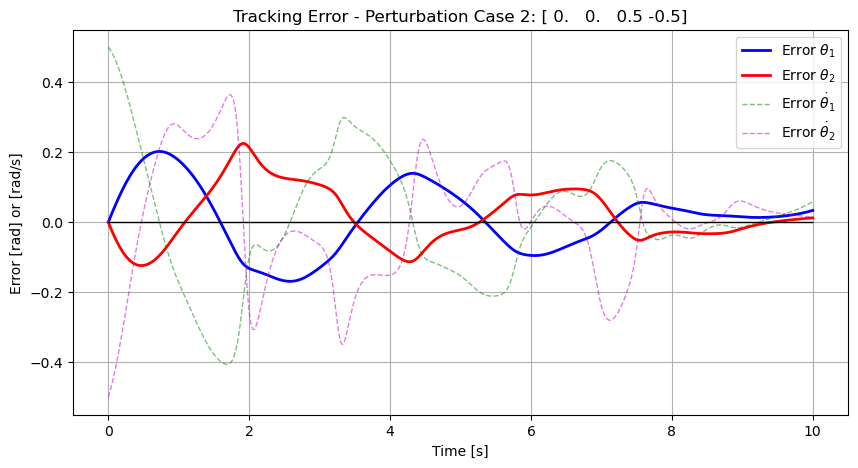

Starting Tracking with Perturbation: [-0.2  0.2  0.1 -0.1]


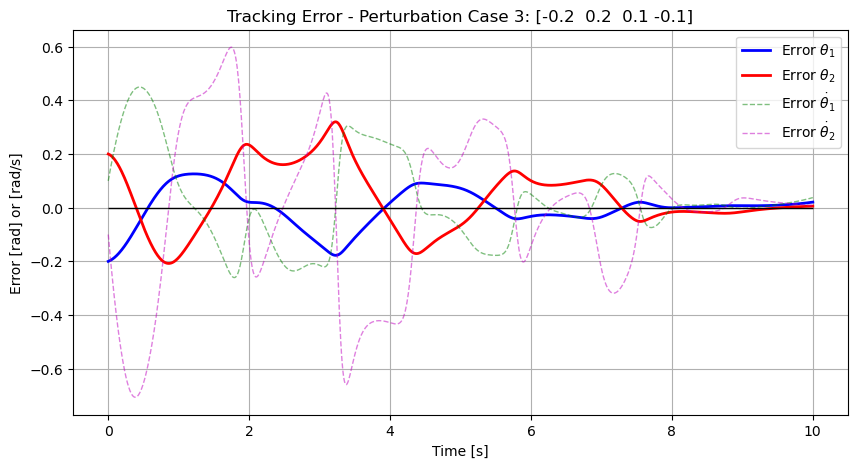

In [9]:
# 1. Initialize Tracker
tracker = LQRTracker(robot, x_opt, u_opt, solver.dt)
tracker.compute_gains()

# Define 3 different perturbations to test
# Perturbation 1: Small deviation (Standard test)
# Perturbation 2: Medium deviation on velocities
# Perturbation 3: Disturbance on both positions and velocities
perturbations_list = [
    np.array([0.5, -0.3, 0.0, 0.0]),  
    np.array([0.0, 0.0, 0.5, -0.5]),   
    np.array([-0.2, 0.2, 0.1, -0.1])   
]

# Store results for the first case to generate the combined Plot 1
x_track_main, u_track_main = tracker.simulate_tracking(perturbations_list[0])

# ==========================================
# FIGURE 1: Trajectory & Inputs (Case 1)
# ==========================================
time = solver.time_grid

plt.figure(figsize=(10, 8))

# Subplot 1: Angles (Theta 1 & Theta 2)
plt.subplot(2, 1, 1)
plt.plot(time, tracker.x_gen[:, 0], 'k--', linewidth=1.5, label=r'$\theta_1$ Desired')
plt.plot(time, x_track_main[:, 0], 'b-', linewidth=2, label=r'$\theta_1$ Actual')
plt.plot(time, tracker.x_gen[:, 1], 'k:', linewidth=1.5, label=r'$\theta_2$ Desired')
plt.plot(time, x_track_main[:, 1], 'r-', linewidth=2, label=r'$\theta_2$ Actual')
plt.ylabel('Angle [rad]')
plt.title(f'LQR Tracking Performance (Perturbation: {perturbations_list[0]})')
plt.legend(loc='best')
plt.grid(True)

# Subplot 2: Input Effort
plt.subplot(2, 1, 2)
plt.plot(time[:-1], tracker.u_gen, 'k--', linewidth=1.5, label='Feedforward (Nominal)')
plt.plot(time[:-1], u_track_main, 'g-', linewidth=2, alpha=0.8, label='Total Input (LQR)')
plt.ylabel('Torque [Nm]')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# FIGURES 2, 3, 4: Tracking Errors
# ==========================================

for i, pert in enumerate(perturbations_list):
    x_track, _ = tracker.simulate_tracking(pert)
    error = x_track - tracker.x_gen
    
    plt.figure(figsize=(10, 5))
    plt.plot(time, error[:, 0], 'b-', linewidth=2, label=r'Error $\theta_1$')
    plt.plot(time, error[:, 1], 'r-', linewidth=2, label=r'Error $\theta_2$')
    plt.plot(time, error[:, 2], 'g--', linewidth=1, alpha=0.5, label=r'Error $\dot{\theta}_1$')
    plt.plot(time, error[:, 3], 'm--', linewidth=1, alpha=0.5, label=r'Error $\dot{\theta}_2$')
    
    plt.hlines(0, time[0], time[-1], 'k', linewidth=1) # Zero line
    plt.ylabel('Error [rad] or [rad/s]')
    plt.xlabel('Time [s]')
    plt.title(f'Tracking Error - Perturbation Case {i+1}: {pert}')
    plt.legend()
    plt.grid(True)
    plt.show()

## **Task 4: Trajectory Tracking via MPC**



In [5]:
class MPC_Tracker_Stable:
    def __init__(self, robot, x_ref, u_ref, x_target, horizon_steps=25):
        self.robot = robot
        self.dt = 0.01 
        self.x_ref_full = x_ref
        self.u_ref_full = u_ref
        self.x_target = x_target # This is your self.x_eq2 (Swing-up target)
        self.total_steps = u_ref.shape[0]
        
        self.N = horizon_steps
        self.nx = 4
        self.nu = 1
        
        # --- STABILITY TUNING ---
        # High Q to keep tracking tight
        self.Q_mpc = sparse.diags([1000.0, 1000.0, 100.0, 100.0]) 
        self.R_mpc = sparse.eye(1) * 0.1                      
        
        # Terminal Cost P: Acts as the "Infinite Horizon" cost anchor
        # We set this very high to force convergence to the target at the end of horizon
        self.P_mpc = sparse.diags([10000.0, 10000.0, 5000.0, 5000.0])



    def get_derivatives_fd(self, x, u): # Linearization of the non-linear dynamics about the feasible optimal trajectory
        """
        Finite Difference calculation of Jacobians A, B.
        """
        eps = 1e-6
        nx, nu = 4, 1
        A = np.zeros((nx, nx)) 
        B = np.zeros((nx, nu)) 
        
        # Center point 
        f0 = self.robot.discrete_step_rk4(x, u, self.dt)
        
        for i in range(nx):
            x_inc = x.copy(); x_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x_inc, u, self.dt)
            A[:, i] = (f_inc - f0) / eps
            
        for i in range(nu):
            u_inc = u.copy(); u_inc[i] += eps
            f_inc = self.robot.discrete_step_rk4(x, u_inc, self.dt)
            B[:, i] = (f_inc - f0) / eps
            
        return A, B

    def solve_mpc_step(self, t, x_measured):
        # We plan N steps ahead. 
        # If we are near the end, we "pad" the reference with the target equilibrium
        horizon = self.N 
        n_vars = horizon * (self.nx + self.nu) + self.nx
        
        # 1. Hessian H
        P_blocks = []
        for _ in range(horizon):
            P_blocks.append(self.Q_mpc)
            P_blocks.append(self.R_mpc)
        P_blocks.append(self.P_mpc) # The Terminal Anchor
        H = sparse.block_diag(P_blocks, format='csc')
        q = np.zeros(H.shape[0])

        # 2. Constraints (LTV dynamics along the horizon)
        A_eq = np.zeros((self.nx * (horizon + 1), n_vars))
        b_eq = np.zeros(self.nx * (horizon + 1))
        
        # Initial condition: dx0
        A_eq[0:4, 0:4] = np.eye(4)
        b_eq[0:4] = x_measured - self.x_ref_full[t]
        
        for k in range(horizon):
            # Index handling for reference (clamping to the end of the trajectory)
            ref_idx = min(t + k, self.total_steps - 1)
            A_k, B_k = self.get_derivatives_fd(self.x_ref_full[ref_idx], self.u_ref_full[ref_idx])
            
            row = (k+1)*4
            idx_x_k, idx_u_k, idx_x_next = k*5, k*5+4, (k+1)*5
            
            A_eq[row:row+4, idx_x_k:idx_x_k+4] = -A_k
            A_eq[row:row+4, idx_u_k:idx_u_k+1] = -B_k
            A_eq[row:row+4, idx_x_next:idx_x_next+4] = np.eye(4)

        # 3. Solve
        prob = osqp.OSQP()
        prob.setup(H, q, sparse.csc_matrix(A_eq), b_eq, b_eq, verbose=False)
        res = prob.solve()
        
        if res.info.status != 'solved':
            return np.zeros(1)
        return res.x[4:5] # Apply delta_u_0

    def simulate(self, x0_perturbed):
        x_sim = np.zeros((self.total_steps + 1, 4))
        u_sim = np.zeros((self.total_steps, 1))
        x_sim[0] = x0_perturbed
        for t in range(self.total_steps):
            du = self.solve_mpc_step(t, x_sim[t])
            u_sim[t] = self.u_ref_full[t] + du
            x_sim[t+1] = self.robot.discrete_step_rk4(x_sim[t], u_sim[t], self.dt)
        return x_sim, u_sim

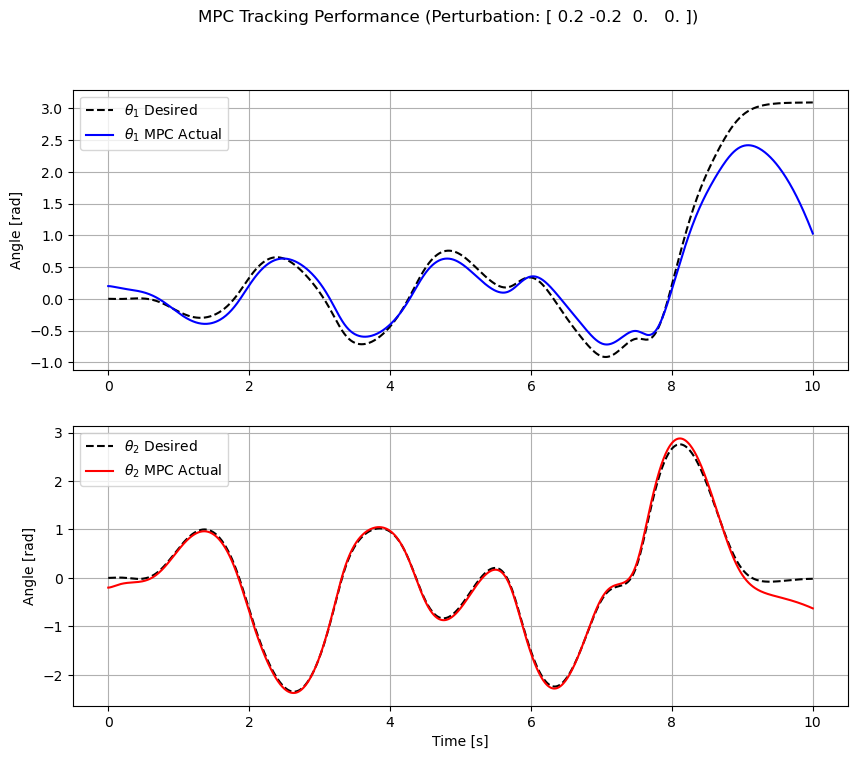

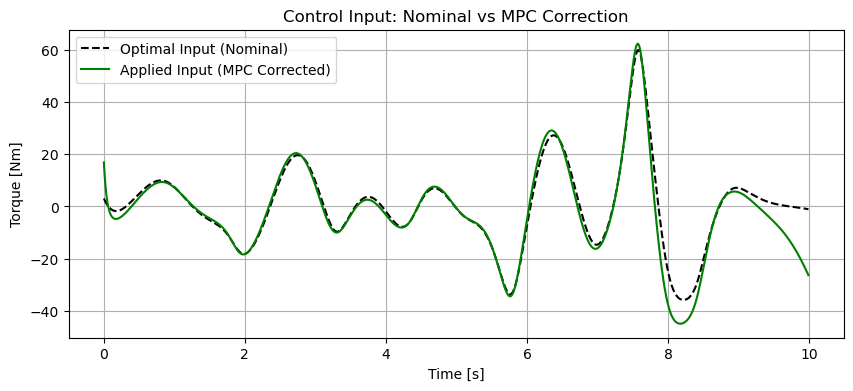

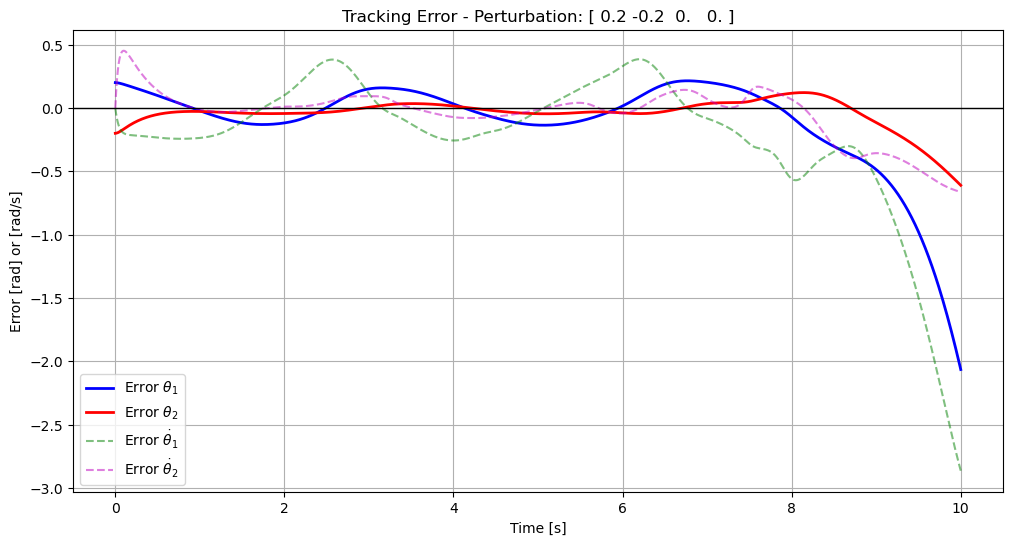

In [6]:
# Setup simulation with perturbation
perturbation = np.array([0.2, -0.2, 0.0, 0.0])
x_terminal = np.array([np.pi, 0.0, 0.0, 0.0])
mpc = MPC_Tracker_Stable(robot, x_opt, u_opt, x_terminal)
x_mpc, u_mpc = mpc.simulate(x_opt[0] + perturbation)

time = np.linspace(0, 10, len(u_mpc) + 1)

# --- GRAPH 1: Trajectory Performance ---
fig1, ax1 = plt.subplots(2, 1, figsize=(10, 8))
ax1[0].plot(time, x_opt[:, 0], 'k--', label=r'$\theta_1$ Desired')
ax1[0].plot(time, x_mpc[:, 0], 'b', label=r'$\theta_1$ MPC Actual')
ax1[0].set_ylabel('Angle [rad]')
ax1[0].legend(); ax1[0].grid(True)

ax1[1].plot(time, x_opt[:, 1], 'k--', label=r'$\theta_2$ Desired')
ax1[1].plot(time, x_mpc[:, 1], 'r', label=r'$\theta_2$ MPC Actual')
ax1[1].set_ylabel('Angle [rad]')
ax1[1].set_xlabel('Time [s]')
ax1[1].legend(); ax1[1].grid(True)
plt.suptitle(f"MPC Tracking Performance (Perturbation: {perturbation})")

# --- GRAPH 2: Optimal vs Applied Input ---
plt.figure(figsize=(10, 4))
plt.plot(time[:-1], u_opt, 'k--', label='Optimal Input (Nominal)')
plt.plot(time[:-1], u_mpc, 'g', label='Applied Input (MPC Corrected)')
plt.ylabel('Torque [Nm]'); plt.xlabel('Time [s]')
plt.title("Control Input: Nominal vs MPC Correction")
plt.legend(); plt.grid(True)

# --- GRAPH 3: Error Tracking Breakdown ---
error = x_mpc - x_opt
plt.figure(figsize=(12, 6))
plt.plot(time, error[:, 0], 'b', linewidth=2, label=r'Error $\theta_1$')
plt.plot(time, error[:, 1], 'r', linewidth=2, label=r'Error $\theta_2$')
plt.plot(time, error[:, 2], 'g--', alpha=0.5, label=r'Error $\dot{\theta}_1$')
plt.plot(time, error[:, 3], 'm--', alpha=0.5, label=r'Error $\dot{\theta}_2$')
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Time [s]'); plt.ylabel('Error [rad] or [rad/s]')
plt.title(f"Tracking Error - Perturbation: {perturbation}")
plt.legend(); plt.grid(True)
plt.show()